In [91]:
import pandas as pd
import numpy as np
import pandas as pd
from pandas import DataFrame
from datetime import datetime
from typing import Optional, Union
import sys
import talib.abstract as ta
import pandas_ta as pta
from technical import qtpylib
import matplotlib.pyplot as plt

In [167]:
class test_strategy():

    buy_move_distance_round=0.008
    buy_move_klines_entry = 3
    buy_move_distance_entry = 0.003
    buy_up_distance_raito = 0.8
    buy_down_distance_ratio = 0.8
    
    def calcualte_peak_vally_stats(self,dataframe: DataFrame,metadata:dict = None)-> DataFrame:
            up_distance = []
            down_distance = []

            up_index_interval = []
            down_index_interval = []

            peak_df = dataframe.loc[(dataframe['peak_vally_bar']==1),:]
            vally_df = dataframe.loc[(dataframe['peak_vally_bar']==-1),:]

            start_index = peak_df.index[0] if peak_df.index[0] < vally_df.index[0] else vally_df.index[0]
            peak_first = (peak_df.index[0] < vally_df.index[0])

            if peak_first:
                for i, peak_idx in enumerate(peak_df.index):
                    peak_close_value = peak_df[peak_idx,'close']
                    if i+1 > len(vally_df.index):
                        break
                    vally_idx = vally_df.index[i]
                    if vally_idx < peak_idx:
                        raise ValueError("vally idx must follow the peak idx in peak first  data mode!")
                    vally_close_value = vally_df[vally_idx,'close']
                    down_distance.append(2.0*abs(vally_close_value-peak_close_value)/(vally_close_value+peak_close_value))
                    down_index_interval.append(vally_idx-peak_idx)

                    if i+1>len(peak_df.index):
                        break
                    next_peak_idx = peak_df.index[i+1]
                    next_peak_close_value = peak_df[next_peak_idx,'close']
                    up_distance.append(2.0*abs(next_peak_close_value-vally_close_value)/(next_peak_close_value+vally_close_value))
                    up_index_interval.append(next_peak_idx-vally_idx)
            else:
                for i, vally_idx in enumerate(vally_df.index):
                    vally_close_value = vally_df[vally_idx,'close']
                    if i+1 > len(peak_df.index):
                        break
                    peak_idx = peak_df.index[i]
                    if vally_idx > peak_idx:
                        raise ValueError("vally idx must follow the peak idx in vally first data mode!")
                    peak_close_value = peak_df[peak_idx,'close']
                    up_distance.append(2.0*abs(vally_close_value-peak_close_value)/(peak_close_value+vally_close_value))
                    up_index_interval.append(peak_idx-vally_idx)
                    if i+1>len(vally_df.index):
                        break
                    next_vally_idx = vally_df.index[i+1]
                    next_vally_close_value = vally_df[next_vally_idx,'close']
                    down_distance.append(2.0*abs(next_vally_close_value-peak_close_value)/(next_vally_close_value+peak_close_value))
                    down_index_interval.append(next_vally_idx-peak_idx)
                    

            up_distance_avg = np.mean(up_distance)
            down_distance_avg = np.mean(down_distance)
            up_down_distance_avg = np.mean(up_distance+down_distance)
            up_klines_avg = np.mean(up_index_interval)
            down_klines_avg = np.mean(down_index_interval)
            up_down_klines_avg = np.mean(up_index_interval + down_index_interval)

            up_distance_total = np.sum(up_distance)
            down_distance_total = np.sum(down_distance)

            stats = {
                'up_dist': up_distance_total,
                'down_dist': down_distance_total,
                'up_avg': up_distance_avg,
                'down_avg': down_distance_avg,
                'up_down_avg': up_down_distance_avg,
                'up_kl_avg': up_klines_avg,
                'down_kl_avg': down_klines_avg,
                'up_down_kl_avg': up_down_klines_avg
            }

            return stats


    def detect_klines_peak_vally_bar(self,dataframe: DataFrame, metadata:dict= None)-> DataFrame:
        """
        detect peak and vally bar use the 'close' value , 
        if peak, mark as value 1, peak means current_bar > left_bar && current_bar > left_bar
        vally marked as value -1, vally means current_bar < left_bar && current_bar < left_bar
        """
        dataframe['peak_vally_bar'] = 0
        dataframe['high_close_avg'] = (0.7*dataframe['close'] + 0.3*dataframe['high'])

        coef = 0.00001

        dataframe.loc[
            (   
                (dataframe['date'].values < dataframe['date'].values[-3]) &   # values before last two shift
                (dataframe['high_close_avg'] > dataframe['high_close_avg'].shift(1)) &  # high_close 大于左一
                (dataframe['high_close_avg'] > dataframe['high_close_avg'].shift(2)) &  # high_close 大于左二
                #(dataframe['high_close_avg'] > dataframe['high_close_avg'].shift(3)) &  # high_close 大于左二
                (dataframe['high_close_avg'] > dataframe['high_close_avg'].shift(-1)) & # high_close 大于右一
                (dataframe['high_close_avg'] > dataframe['high_close_avg'].shift(-2))    # high_close 大于右2
                #(dataframe['high_close_avg'] > dataframe['high_close_avg'].shift(-3))    # high_close 大于右2
                #(dataframe['high_close_avg'].shift(1) > dataframe['high_close_avg'].shift(2)) & 
                #(dataframe['high_close_avg'].shift(-1) > dataframe['high_close_avg'].shift(-2)) &
                #(dataframe['close']*(1-coef) > dataframe['close'].shift(2)) & 
                #(dataframe['close']*(1-coef) > dataframe['close'].shift(-2))

            ),
            'peak_vally_bar'] = 1

        dataframe.loc[
            (
                (dataframe['date'].values < dataframe['date'].values[-3]) &   # 取值后2之前
                (dataframe['high_close_avg'] < dataframe['high_close_avg'].shift(1)) &  # high_close 小于左一
                (dataframe['high_close_avg'] < dataframe['high_close_avg'].shift(2)) &  # high_close 小于左二
                #(dataframe['high_close_avg'] < dataframe['high_close_avg'].shift(3)) &  # high_close 小于左二
                (dataframe['high_close_avg'] < dataframe['high_close_avg'].shift(-1))& # high_close 小于右一
                (dataframe['high_close_avg'] < dataframe['high_close_avg'].shift(-2))   # high_close 小于右2
                #(dataframe['high_close_avg'] < dataframe['high_close_avg'].shift(-3))   # high_close 小于右2
                #(dataframe['high_close_avg'].shift(1) < dataframe['high_close_avg'].shift(2)) & 
                #(dataframe['high_close_avg'].shift(-1) < dataframe['high_close_avg'].shift(-2))

                #(dataframe['close']*(1+coef) < dataframe['close'].shift(2)) & 
                #(dataframe['close']*(1+coef) < dataframe['close'].shift(-2))
                
            ),
            'peak_vally_bar'] = -1

        return dataframe


    def populate_indicators(self,dataframe: DataFrame, metadata: dict= None) -> DataFrame:
        """
        Adds several different TA indicators to the given DataFrame

        Performance Note: For the best performance be frugal on the number of indicators
        you are using. Let uncomment only the indicator you are using in your strategies
        or your hyperopt configuration, otherwise you will waste your memory and CPU usage.
        :param dataframe: Dataframe with data from the exchange
        :param metadata: Additional information, like the currently traded pair
        :return: a Dataframe with all mandatory indicators for the strategies
        """

        # Momentum Indicators
        # ------------------------------------
        # EMA - Exponential Moving Average
        dataframe['ema3'] = ta.EMA(dataframe, timeperiod=3)
        dataframe['ema5'] = ta.EMA(dataframe, timeperiod=5)
        dataframe['ema10'] = ta.EMA(dataframe, timeperiod=10)
        # dataframe['ema21'] = ta.EMA(dataframe, timeperiod=21)
        # dataframe['ema50'] = ta.EMA(dataframe, timeperiod=50)
        # dataframe['ema100'] = ta.EMA(dataframe, timeperiod=100)

        dataframe = self.detect_klines_peak_vally_bar(dataframe,metadata)

    
        return dataframe

    def populate_entry_trend(self,dataframe: DataFrame, metadata: dict= None) -> DataFrame:
        """
        Based on TA indicators, populates the entry signal for the given dataframe
        :param dataframe: DataFrame
        :param metadata: Additional information, like the currently traded pair
        :return: DataFrame with entry columns populated
        """

        stats = self.calcualte_peak_vally_stats(dataframe,metadata)

        up_avg = stats['up_avg']
        down_avg = stats['down_avg']

        up_dist = stats['up_dist']
        down_dist = stats['down_dist']
        up_down_avg = stats['up_down_avg']
        up_kl_avg = stats['up_kl_avg']
        down_kl_avg = stats['down_kl_avg']
        up_down_kl_avg = stats['up_down_kl_avg']

        move_range = self.buy_move_distance_round
        klines_entry = self.buy_move_klines_entry
        move_range_entry_ratio = self.buy_move_distance_entry
        move_range_entry = move_range_entry_ratio* move_range

        up_down_ratio = round(up_dist/down_dist,4)
        up_dist_ratio  = self.buy_up_distance_raito
        down_dist_ratio = self.buy_down_distance_ratio




        if up_avg > move_range and up_down_ratio > up_dist_ratio:
            dataframe.loc[
                (
                    (dataframe['close'] >= dataframe['ema5']) &                     # 站上3周期平均线
                    (dataframe['close'] >= dataframe['open']) &                     # k-0 bar 上涨
                    (dataframe['close'].shift(1) > dataframe['open'].shift(1)) &    # k-1 bar 上涨
                    (dataframe['close'].shift(2) > dataframe['open'].shift(2)) &    # k-2 bar 上涨
                    (dataframe['close'].shift(3) < dataframe['open'].shift(3)) &    # k-3 bar 下跌
                    (dataframe['close'] > dataframe['close'].shift(1)) &            # close0 > close1
                    (dataframe['close'].shift(1) > dataframe['close'].shift(2)) &   # close1 > close2
                    (dataframe['close']-dataframe['close'].shift(2) > move_range_entry) &  # 价格移动距离超过一定比例
                    (dataframe['volume'] > 0)                                      # 有成交量
                ),
                'enter_long'] = 1

        if down_avg > move_range and (1/up_down_ratio) > down_dist_ratio:
            dataframe.loc[
                (
                    (dataframe['close'] < dataframe['ema5']) &                      # 落入3周期平均线
                    (dataframe['close'] < dataframe['open']) &                      # k-0 bar 下跌
                    (dataframe['close'].shift(1) < dataframe['open'].shift(1)) &    # k-1 bar 下跌
                    (dataframe['close'].shift(2) < dataframe['open'].shift(2)) &    # k-2 bar 下跌
                    (dataframe['close'].shift(3) > dataframe['open'].shift(3)) &    # k-3 bar 上涨
                    (dataframe['close'] < dataframe['close'].shift(1)) &            # close价格下跌
                    (dataframe['close'].shift(1) < dataframe['close'].shift(2)) &   # close价格下跌
                    (dataframe['close'].shift(2)-dataframe['close'] > move_range_entry) &  # 价格移动距离超过一定比例
                    (dataframe['volume'] > 0)                                      # 有成交量
                ),
                'enter_short'] = 1


        return dataframe

    def populate_exit_trend(self, dataframe: DataFrame, metadata: dict= None) -> DataFrame:
        """
        Based on TA indicators, populates the exit signal for the given dataframe
        :param dataframe: DataFrame
        :param metadata: Additional information, like the currently traded pair
        :return: DataFrame with exit columns populated
        """
        # dataframe.loc[
        #     (
        #         (qtpylib.crossed_above(dataframe['rsi'], self.sell_rsi.value)) &  # Signal: RSI crosses above sell_rsi
        #         (dataframe['tema'] > dataframe['bb_middleband']) &  # Guard: tema above BB middle
        #         (dataframe['tema'] < dataframe['tema'].shift(1)) &  # Guard: tema is falling
        #         (dataframe['volume'] > 0)  # Make sure Volume is not 0
        #     ),
        #     'exit_long'] = 1
        # Uncomment to use shorts (Only used in futures/margin mode. Check the documentation for more info)
        """
        dataframe.loc[
            (
                (qtpylib.crossed_above(dataframe['rsi'], self.buy_rsi.value)) &  # Signal: RSI crosses above buy_rsi
                (dataframe['tema'] <= dataframe['bb_middleband']) &  # Guard: tema below BB middle
                (dataframe['tema'] > dataframe['tema'].shift(1)) &  # Guard: tema is raising
                (dataframe['volume'] > 0)  # Make sure Volume is not 0
            ),
            'exit_short'] = 1
        """
        return dataframe
        


In [168]:
df = pd.read_feather("../data/gateio/futures/BTC_USDT_USDT-1m-futures.feather")
to = test_strategy()
df = to.detect_klines_peak_vally_bar(df)


In [169]:
df_close = df['close']
df_high_close = df['high_close_avg']
df_pv = pd.DataFrame(df['peak_vally_bar'])
df_pv_1 = df_pv.loc[df_pv['peak_vally_bar']==1,:]
df_pv_2 = df_pv.loc[df_pv['peak_vally_bar']==-1,:]


In [170]:
df_high_close_pv_1 = df_high_close[df_pv_1.index]
df_high_close_pv_2 = df_high_close[df_pv_2.index]

In [171]:
df_high_close_pv_1

7         16534.00
15        16520.63
27        16541.28
40        16522.63
48        16528.00
            ...   
380679    26685.60
380690    26662.00
380707    26651.60
380717    26642.59
380726    26619.20
Name: high_close_avg, Length: 43850, dtype: float64

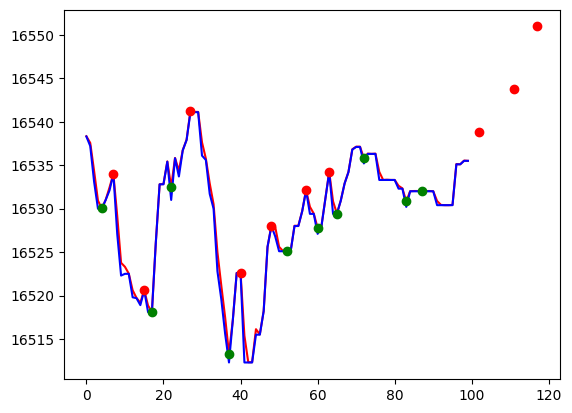

In [173]:
#plt.plot(df_close,color='blue')
plt.plot(df_high_close[0:100],color='red')
plt.plot(df_close[0:100],color='blue')
plt.plot(df_high_close_pv_1[0:10],'ro')
plt.plot(df_high_close_pv_2[0:10],'go')
plt.show()

In [ ]:
df = to.populate_indicators(df)


In [ ]:
df = to.populate_entry_trend(df)


In [ ]:
df = to.populate_exit_trend(df)